# NOVO BANCO - Data Science Challenge
---
---

Part II - In this part, we will deep dive on the data, and see if there are more features to be extracted that can be discriminative enough for our classifier.

In [139]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct, col, count, substring, collect_list, concat_ws, concat, avg, date_format, to_timestamp, lit, hour
from pyspark.sql.types import StringType
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Ingestion
---

Create Apache Spark environment:

In [2]:
spark = SparkSession.builder.appName("CTR").getOrCreate()

In [136]:
df = spark.read.csv("../data/small_train.gz", inferSchema=True, header=True)

In [4]:
df.count()

500000

Original Schema of the data:

In [5]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



### Original Features Description
---

* `id`: Ad identifier
* `click`: 0/1 for non-click/click (target variable)
* `hour`: Timestamp (UTC) - Format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* `C1`: Anonymized categorical variable
* `banner_pos`: Banner position.
* `site_id`: Site identifier.
* `site_domain`: Site domain.
* `site_category`: Site category.
* `app_id`: App identifier.
* `app_domain`: App domain.
* `app_category`: App category.
* `device_id`: Device identifier.
* `device_ip`: Device IP address.
* `device_model`: Device model.
* `device_type`: Device type.
* `device_conn_type`: Device connection type.
* `C14-C21`: Unnamed categorical variables.

In [6]:
display(df.show(4))

+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|_c0|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
| 24|10005249248600844288|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e99d0c2e|    d25693ce|          1|               0|15706|320| 50|1722|  0| 35|100083| 79|
| 77|10013378798301872128|    1|14102100|1005|         1|e151e245|   7e091613|     f028772b|ecad

None

Quantity of unique values for each feature. Given the impressive cardinality of some of the features, one-hot encoding them would lead to a very sparse matrix. I will have to deal with this, probably using some kind lower-rank representation of the data.

In [7]:
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show(10)

+------+------+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
|   _c0|    id|click|hour| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type| C14|C15|C16|C17|C18|C19|C20|C21|
+------+------+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
|500000|500000|    2| 240|  7|         7|   2282|       2334|           22|  2427|       150|          26|    79113|   313632|        4564|          5|               4|2117|  8|  9|422|  4| 66|158| 60|
+------+------+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---

As expected, its more common for a user do not click to click. This is shown by the class imbalance present in this dataset:

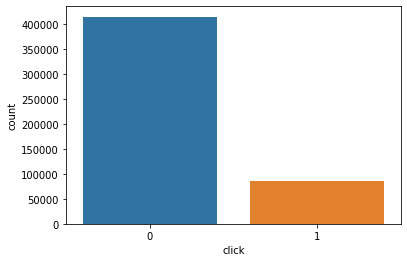

In [8]:
df_pd = df.toPandas()
sns.countplot(df_pd["click"])

In [10]:
df_pd['click'].value_counts() / len(df_pd)

0    0.830018
1    0.169982
Name: click, dtype: float64

## Feature Examination & Exploration
---

### Temporal Features

Lets first build the basic temporal units: `hour_of_day`, `day_of_week`:

In [141]:
df = df.withColumn("hour", col("hour").cast(StringType()))\
.withColumn("hour", concat(lit(20), concat(col("hour")))) \
.withColumn("hour", to_timestamp(col("hour"), format="yyyyMMddHH")) \
.withColumn("hour_of_day", hour(col("hour"))) \
.withColumn("day_of_week", date_format(col("hour"), "EEEE"))

In [150]:
df.show(10)

+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+
|_c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|hour_of_day|day_of_week|
+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+
| 24|10005249248600844288|    0|2014-10-21 00:00:00|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e99d0c2e|    d25693ce|          1|               0|15706|320| 50|17

In [13]:
df_pd = df.toPandas()

In [14]:
df_pd['hour'] = pd.to_datetime(df_pd["hour"], format="%y%m%d%H")

In [15]:
max(df_pd.hour) - min(df_pd.hour)

Timedelta('9 days 23:00:00')

In the plot below the number of overall clicks per hour can be observed. From this, we can see a strong cyclical behaviour, as it is expected.

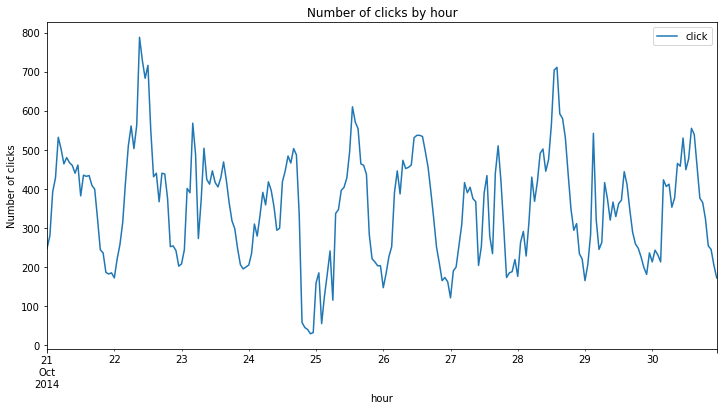

In [16]:
df_pd.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

In the plot below, we can see the number of clicks per hour of the day. From this plot, we can see that we have a peak at around 5 a.m. (probably first commuters), then another peak before 10 a.m. (probably late commuters), and a peak around lunch hour. 

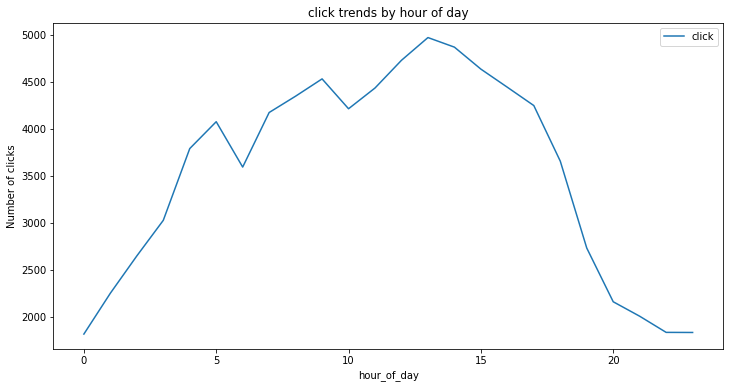

In [17]:
df_pd['hour_of_day'] = df_pd.hour.apply(lambda x: x.hour)
df_pd.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

In the plot below, my idea was to check if there are a specific time or interval of the day when people have a tendency to click more. As supported from the plot above, we can see the early morning peak, the late morning peak and lunch hour. No big change in terms of the clicks.

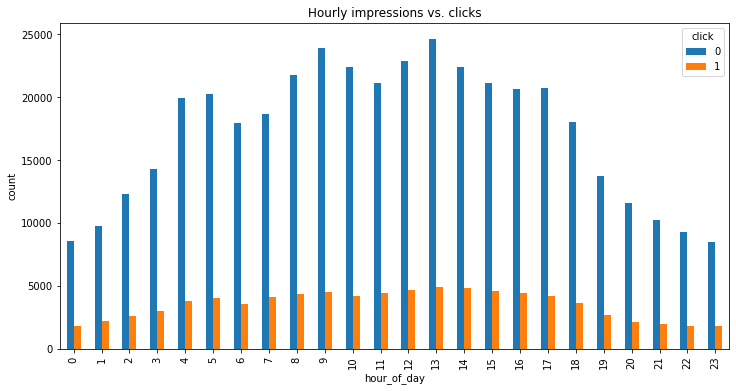

In [18]:
df_pd.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

In the plot below, I went after the click-through rate directly. We can see that is somewhat constant throughout the day.

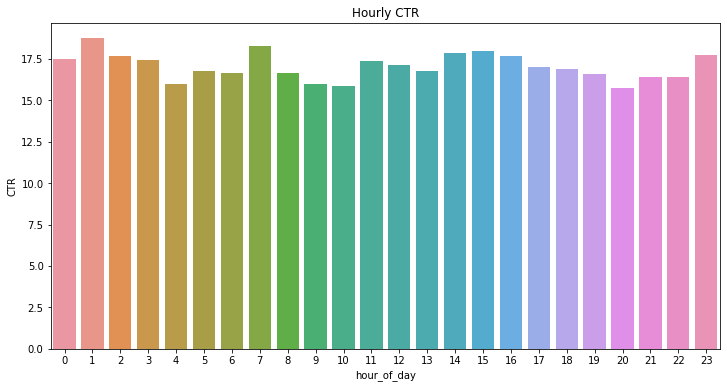

In [19]:
df_click = df_pd[df_pd['click'] == 1]
df_hour = df_pd[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

Another interesting propostion (or hypothesis), would be to check if there is a specific day of the week where people click more than the other. It was very interesting to see click more at the beginning of the week.

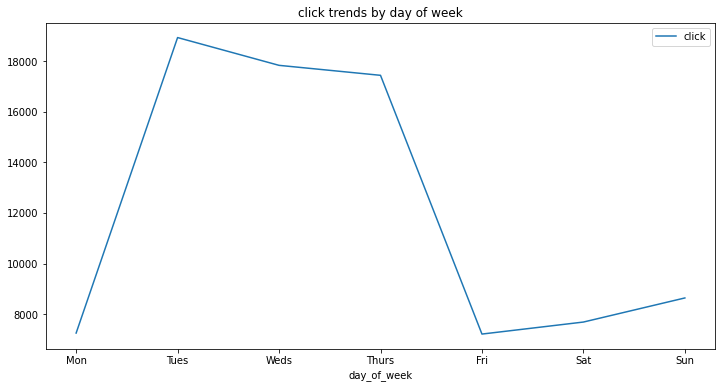

In [20]:
df_pd['day_of_week'] = df_pd['hour'].dt.day_name()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_pd.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1))
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

Again, the same of above but with the ration between impressions and number of clicks.

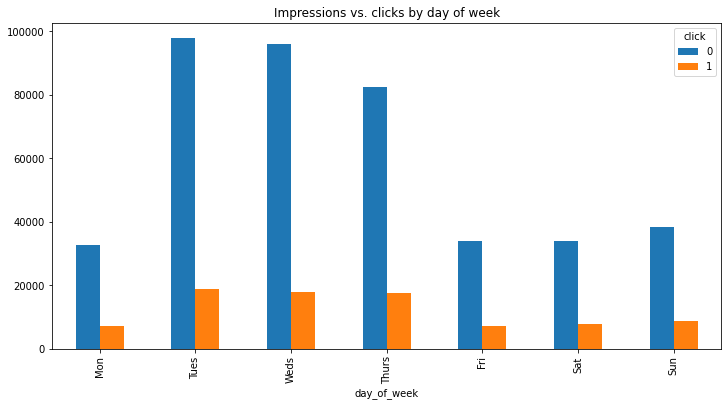

In [21]:
df_pd.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1))
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

In the plot below, I went after the click-through rate directly. We can see that is somewhat constant throughout the week, although a clear trend is present from Wednesday on.

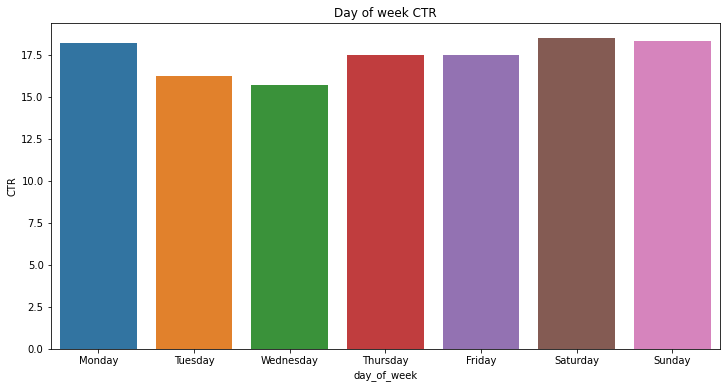

In [22]:
df_click = df_pd[df_pd['click'] == 1]
df_dayofweek = df_pd[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

### Anonymous Feature Analysis.


In the following sections, we will look at the many anonymized features provided. We will go one-by-one and check whether if they are discriminative. 

### C1

In [23]:
print(df_pd.C1.value_counts()/len(df_pd))

1005    0.919154
1002    0.054530
1010    0.022230
1012    0.002774
1007    0.000942
1001    0.000222
1008    0.000148
Name: C1, dtype: float64


In [24]:
C1_values = df_pd.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 1001,  click through rate: 0.009009009009009009
for C1 value: 1002,  click through rate: 0.21335044929396663
for C1 value: 1005,  click through rate: 0.16931656719113444
for C1 value: 1007,  click through rate: 0.036093418259023353
for C1 value: 1008,  click through rate: 0.12162162162162163
for C1 value: 1010,  click through rate: 0.09833558254610886
for C1 value: 1012,  click through rate: 0.17303532804614274


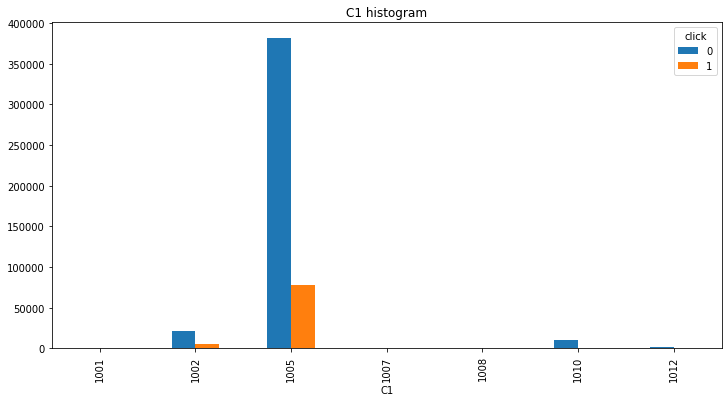

In [25]:
df_pd.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

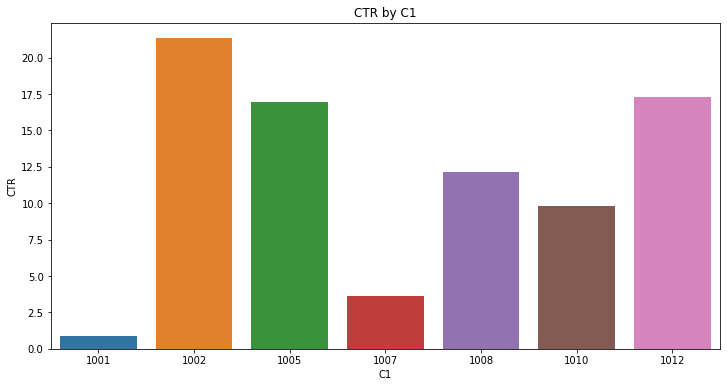

In [26]:
df_c1 = df_pd[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

### C14

In [27]:
print(df_pd.C14.value_counts()/len(df_pd))

4687     0.023336
21611    0.022526
21189    0.019146
21191    0.019022
19772    0.018126
           ...   
18579    0.000002
18321    0.000002
21139    0.000002
18467    0.000002
18423    0.000002
Name: C14, Length: 2117, dtype: float64


In [28]:
C14_values = df_pd.C14.sample(20).tolist()
C14_values.sort()
ctr_avg_list=[]
for i in C14_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C14 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C14 value: {},  click through rate: {}".format(i,ctr_avg))

for C14 value: 15702,  click through rate: 0.15897608622431794
for C14 value: 15703,  click through rate: 0.1882295719844358
for C14 value: 15707,  click through rate: 0.20106075216972036
for C14 value: 16859,  click through rate: 0.1621301775147929
for C14 value: 17212,  click through rate: 0.14763552479815456
for C14 value: 17264,  click through rate: 0.312683284457478
for C14 value: 17753,  click through rate: 0.3833491611269389
for C14 value: 19251,  click through rate: 0.07441101003032424
for C14 value: 19950,  click through rate: 0.12584097859327217
for C14 value: 20071,  click through rate: 0.04865938430983118
for C14 value: 20251,  click through rate: 0.21305721305721306
for C14 value: 20391,  click through rate: 0.11594202898550725
for C14 value: 21408,  click through rate: 0.21621621621621623
for C14 value: 21759,  click through rate: 0.1819484240687679
for C14 value: 21767,  click through rate: 0.10593311758360302
for C14 value: 21767,  click through rate: 0.1059331175836030

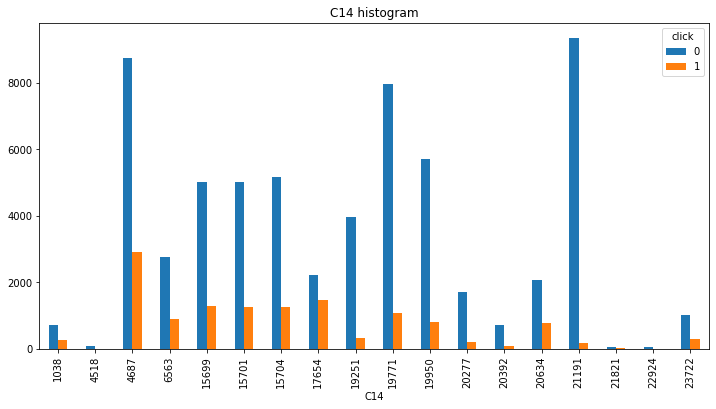

In [29]:
C14_values = df_pd.C14.sample(20).tolist()
df_c14 = df_pd[df_pd.C14.isin(C14_values)]
df_c14.groupby(['C14', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C14 histogram');

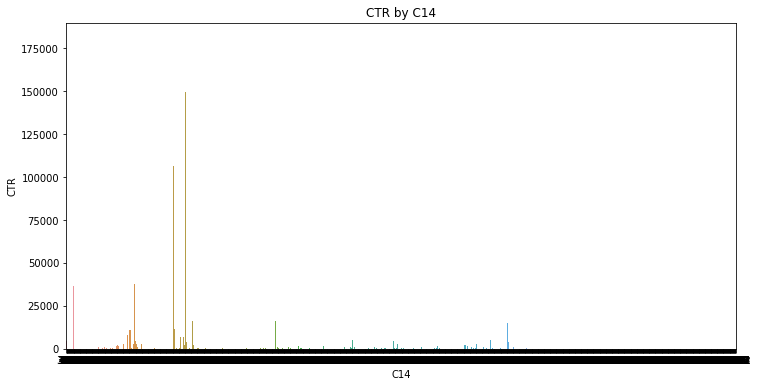

In [30]:
df_c1 = df_pd[['C14','click']].groupby(['C14']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C14','click']].groupby(['C14']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C14', data=df_c1)
plt.title('CTR by C14');

### C15

In [31]:
print(df_pd.C15.value_counts()/len(df_pd))

320     0.932978
300     0.057580
216     0.007406
728     0.001780
120     0.000090
1024    0.000080
480     0.000048
768     0.000038
Name: C15, dtype: float64


In [32]:
C15_values = df_pd.C15.sample(20).tolist()
C15_values.sort()
ctr_avg_list=[]
for i in C15_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C15 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C15 value: {},  click through rate: {}".format(i,ctr_avg))

for C15 value: 300,  click through rate: 0.3609586662035429
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  click through rate: 0.15876044236841597
for C15 value: 320,  clic

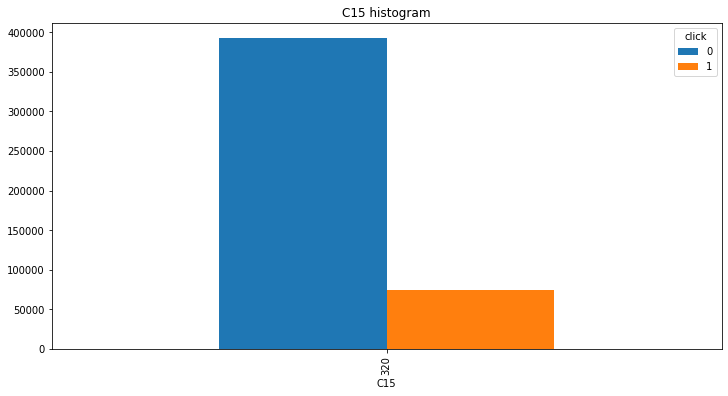

In [33]:
C15_values = df_pd.C15.sample(20).tolist()
df_c15 = df_pd[df_pd.C15.isin(C15_values)]
df_c15.groupby(['C15', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C15 histogram');

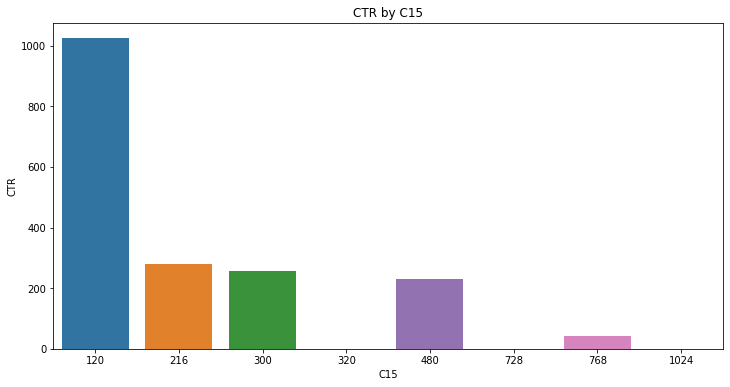

In [34]:
df_c1 = df_pd[['C15','click']].groupby(['C15']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C15','click']].groupby(['C15']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C15', data=df_c1)
plt.title('CTR by C15');

### C16

In [35]:
print(df_pd.C16.value_counts()/len(df_pd))

50      0.943426
250     0.044728
36      0.007406
480     0.002404
90      0.001780
20      0.000090
768     0.000080
320     0.000048
1024    0.000038
Name: C16, dtype: float64


In [36]:
C15_values = df_pd.C16.unique()
C15_values.sort()
ctr_avg_list=[]
for i in C15_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C16 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C16 value: {},  click through rate: {}".format(i,ctr_avg))

for C16 value: 20,  click through rate: 0.0
for C16 value: 36,  click through rate: 0.12449365379422091
for C16 value: 50,  click through rate: 0.15852223703819907
for C16 value: 90,  click through rate: 0.06179775280898876
for C16 value: 250,  click through rate: 0.4211232337685566
for C16 value: 320,  click through rate: 0.2916666666666667
for C16 value: 480,  click through rate: 0.21381031613976706
for C16 value: 768,  click through rate: 0.2
for C16 value: 1024,  click through rate: 0.42105263157894735


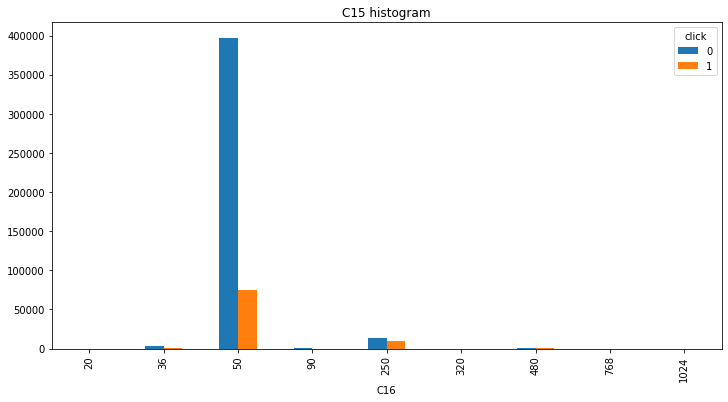

In [37]:
df_c15 = df_pd[df_pd.C16.isin(C15_values)]
df_c15.groupby(['C16', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C15 histogram');

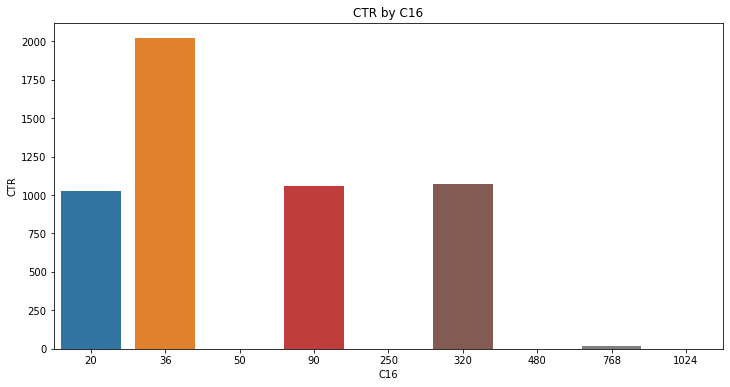

In [38]:
df_c1 = df_pd[['C16','click']].groupby(['C16']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C16','click']].groupby(['C16']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C16', data=df_c1)
plt.title('CTR by C16');

### C17

In [39]:
print(df_pd.C17.value_counts()/len(df_pd))

1722    0.111658
2424    0.038170
2227    0.036476
1800    0.029370
423     0.023336
          ...   
2582    0.000002
2521    0.000002
2447    0.000002
2744    0.000002
2585    0.000002
Name: C17, Length: 422, dtype: float64


In [40]:
C15_values = df_pd.C17.unique()
C15_values.sort()
ctr_avg_list=[]
for i in C15_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C17 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C17 value: {},  click through rate: {}".format(i,ctr_avg))

for C17 value: 112,  click through rate: 0.22977453580901858
for C17 value: 122,  click through rate: 0.13298429319371727
for C17 value: 153,  click through rate: 0.08379888268156424
for C17 value: 178,  click through rate: 0.28205128205128205
for C17 value: 196,  click through rate: 0.16393442622950818
for C17 value: 394,  click through rate: 0.0891089108910891
for C17 value: 423,  click through rate: 0.24965718203633872
for C17 value: 479,  click through rate: 0.21776155717761558
for C17 value: 544,  click through rate: 0.18295739348370926
for C17 value: 547,  click through rate: 0.1326478149100257
for C17 value: 549,  click through rate: 0.19576719576719576
for C17 value: 550,  click through rate: 0.14619883040935672
for C17 value: 571,  click through rate: 0.2109090909090909
for C17 value: 572,  click through rate: 0.24720936564116525
for C17 value: 576,  click through rate: 0.1880597014925373
for C17 value: 613,  click through rate: 0.14231738035264482
for C17 value: 644,  click t

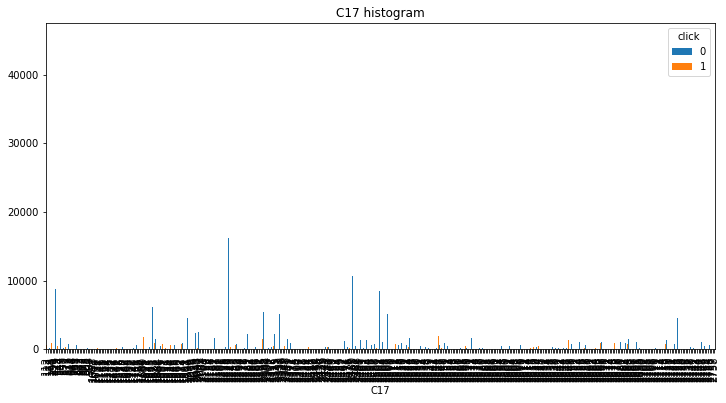

In [41]:
df_c15 = df_pd[df_pd.C17.isin(C15_values)]
df_c15.groupby(['C17', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C17 histogram');

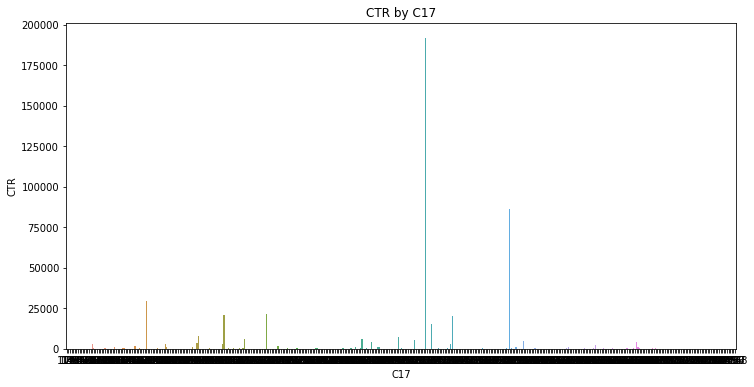

In [42]:
df_c1 = df_pd[['C17','click']].groupby(['C17']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C17','click']].groupby(['C17']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C17', data=df_c1)
plt.title('CTR by C17');

### C18

In [43]:
print(df_pd.C18.value_counts()/len(df_pd))

0    0.418986
3    0.337236
2    0.176142
1    0.067636
Name: C18, dtype: float64


In [44]:
C15_values = df_pd.C18.unique()
C15_values.sort()
ctr_avg_list=[]
for i in C15_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C18 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C18 value: {},  click through rate: {}".format(i,ctr_avg))

for C18 value: 0,  click through rate: 0.15801959970022864
for C18 value: 1,  click through rate: 0.03465610030161453
for C18 value: 2,  click through rate: 0.2957727288210648
for C18 value: 3,  click through rate: 0.146283314948582


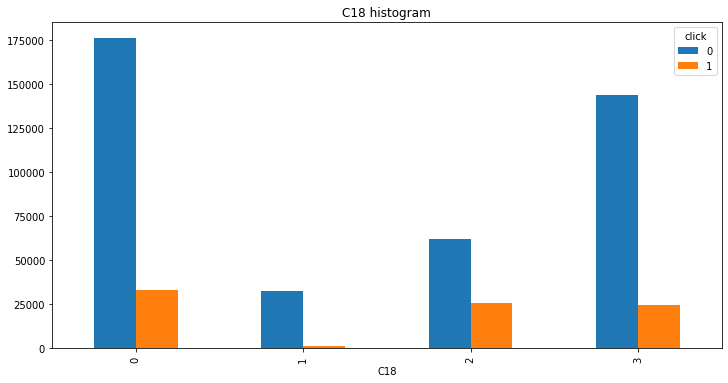

In [45]:
C18_values = df_pd.C18.unique()
df_c15 = df_pd[df_pd.C18.isin(C18_values)]
df_c15.groupby(['C18', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C18 histogram');

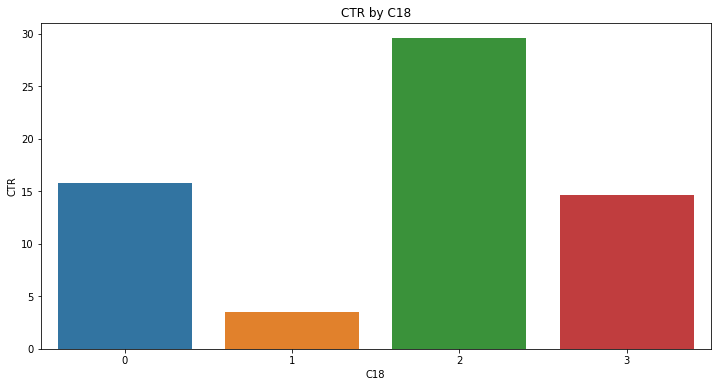

In [46]:
df_c1 = df_pd[['C18','click']].groupby(['C18']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C18','click']].groupby(['C18']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C18', data=df_c1)
plt.title('CTR by C18');

### C19

In [47]:
print(df_pd.C19.value_counts()/len(df_pd))

35      0.301972
39      0.217526
167     0.077736
161     0.039414
47      0.035714
          ...   
45      0.000080
683     0.000022
1195    0.000006
1447    0.000004
545     0.000002
Name: C19, Length: 66, dtype: float64


In [48]:
C15_values = df_pd.C19.unique()
C15_values.sort()
ctr_avg_list=[]
for i in C15_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C19 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C19 value: {},  click through rate: {}".format(i,ctr_avg))

for C19 value: 33,  click through rate: 0.058223684210526316
for C19 value: 34,  click through rate: 0.13050122249388754
for C19 value: 35,  click through rate: 0.16694925357317897
for C19 value: 38,  click through rate: 0.17830478700043917
for C19 value: 39,  click through rate: 0.24501898623612808
for C19 value: 41,  click through rate: 0.10099573257467995
for C19 value: 43,  click through rate: 0.08569182389937106
for C19 value: 45,  click through rate: 0.075
for C19 value: 47,  click through rate: 0.17057736461891695
for C19 value: 161,  click through rate: 0.022986755975034252
for C19 value: 163,  click through rate: 0.09456285341452805
for C19 value: 167,  click through rate: 0.16273026654317177
for C19 value: 169,  click through rate: 0.11198057204533189
for C19 value: 171,  click through rate: 0.10261672652642381
for C19 value: 175,  click through rate: 0.12097169164462729
for C19 value: 289,  click through rate: 0.0958904109589041
for C19 value: 290,  click through rate: 0.159

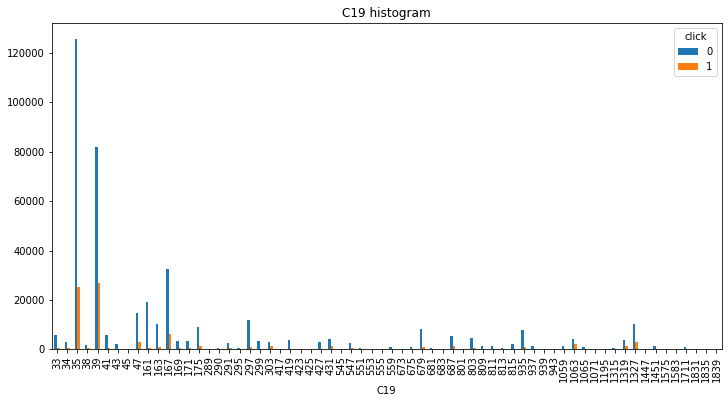

In [49]:
df_c15 = df_pd[df_pd.C19.isin(C15_values)]
df_c15.groupby(['C19', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C19 histogram');

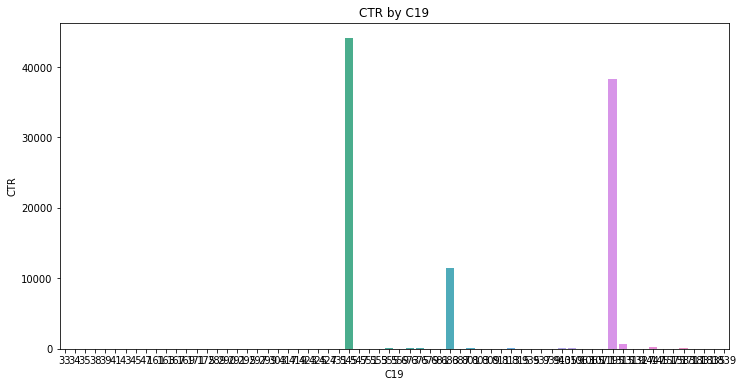

In [50]:
df_c1 = df_pd[['C19','click']].groupby(['C19']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C19','click']].groupby(['C19']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C19', data=df_c1)
plt.title('CTR by C19');

### C20

In [51]:
print(df_pd.C20.value_counts()/len(df_pd))

-1         0.469324
 100084    0.060434
 100148    0.044044
 100111    0.042514
 100077    0.038934
             ...   
 100082    0.000016
 100153    0.000012
 100024    0.000012
 100098    0.000006
 100138    0.000002
Name: C20, Length: 158, dtype: float64


In [52]:
C15_values = df_pd.C20.unique()
C15_values.sort()
ctr_avg_list=[]
for i in C15_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C20 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C20 value: {},  click through rate: {}".format(i,ctr_avg))

for C20 value: -1,  click through rate: 0.19375527354237157
for C20 value: 100000,  click through rate: 0.08933889219773675
for C20 value: 100001,  click through rate: 0.13829787234042554
for C20 value: 100002,  click through rate: 0.04672897196261682
for C20 value: 100003,  click through rate: 0.05732484076433121
for C20 value: 100004,  click through rate: 0.21545893719806763
for C20 value: 100005,  click through rate: 0.056128293241695305
for C20 value: 100010,  click through rate: 0.2222222222222222
for C20 value: 100012,  click through rate: 0.085
for C20 value: 100013,  click through rate: 0.1191969887076537
for C20 value: 100016,  click through rate: 0.1
for C20 value: 100019,  click through rate: 0.17927631578947367
for C20 value: 100020,  click through rate: 0.06523605150214593
for C20 value: 100021,  click through rate: 0.2127371273712737
for C20 value: 100022,  click through rate: 0.32222222222222224
for C20 value: 100024,  click through rate: 0.0
for C20 value: 100025,  clic

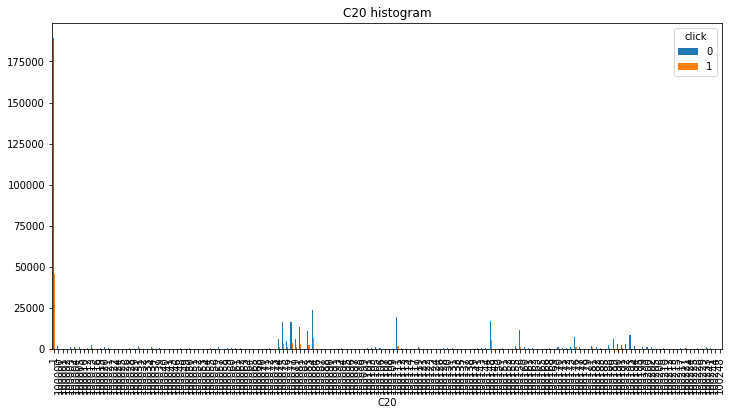

In [53]:
C20_values = df_pd.C20.unique()
df_c15 = df_pd[df_pd.C20.isin(C20_values)]
df_c15.groupby(['C20', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C20 histogram');

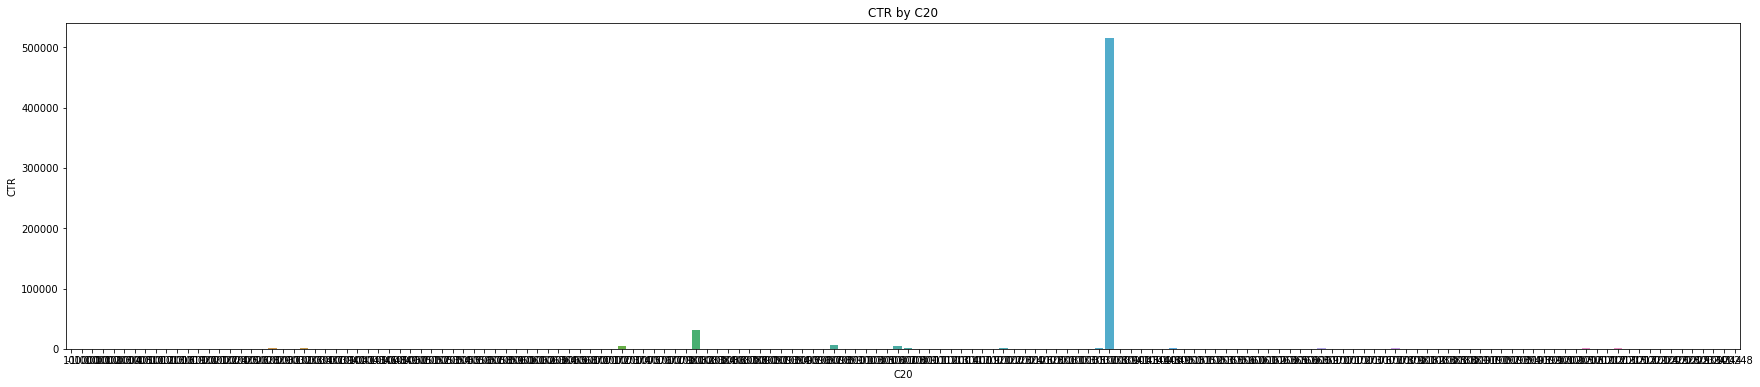

In [54]:
df_c1 = df_pd[['C20','click']].groupby(['C20']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C20','click']].groupby(['C20']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(30,6))
sns.barplot(y='CTR', x='C20', data=df_c1)
plt.title('CTR by C20');

### C21

In [55]:
print(df_pd.C21.value_counts()/len(df_pd))

23     0.219908
221    0.124662
79     0.114276
48     0.053340
71     0.052420
61     0.050526
157    0.045692
32     0.044162
33     0.037336
52     0.029672
42     0.025076
51     0.021274
15     0.018926
212    0.016468
43     0.014800
117    0.010144
229    0.009788
13     0.009554
16     0.008612
156    0.008202
68     0.007932
159    0.007360
95     0.006792
46     0.005732
246    0.005216
69     0.004378
91     0.004330
17     0.004226
111    0.003574
76     0.003354
70     0.003338
90     0.003180
110    0.003042
171    0.002826
204    0.002298
101    0.002010
253    0.001974
82     0.001774
112    0.001744
100    0.001672
182    0.001236
178    0.001198
35     0.001190
108    0.001144
251    0.000490
94     0.000472
116    0.000410
20     0.000358
194    0.000346
93     0.000300
104    0.000218
102    0.000216
126    0.000186
163    0.000158
177    0.000146
255    0.000132
195    0.000090
1      0.000058
219    0.000048
85     0.000014
Name: C21, dtype: float64


In [56]:
C21_values = df_pd.C21.unique()
C21_values.sort()
ctr_avg_list=[]
for i in C21_values:
    ctr_avg=df_pd.loc[np.where((df_pd.C21 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C21 value: {},  click through rate: {}".format(i,ctr_avg))

for C21 value: 1,  click through rate: 0.10344827586206896
for C21 value: 13,  click through rate: 0.21645384132300607
for C21 value: 15,  click through rate: 0.21631617880164852
for C21 value: 16,  click through rate: 0.25429633070134694
for C21 value: 17,  click through rate: 0.08140085186938002
for C21 value: 20,  click through rate: 0.08379888268156424
for C21 value: 23,  click through rate: 0.2128526474707605
for C21 value: 32,  click through rate: 0.232145283275214
for C21 value: 33,  click through rate: 0.3937218770087851
for C21 value: 35,  click through rate: 0.292436974789916
for C21 value: 42,  click through rate: 0.12123145637262721
for C21 value: 43,  click through rate: 0.07054054054054054
for C21 value: 46,  click through rate: 0.09595254710397767
for C21 value: 48,  click through rate: 0.13937007874015747
for C21 value: 51,  click through rate: 0.18520259471655542
for C21 value: 52,  click through rate: 0.2733216500404422
for C21 value: 61,  click through rate: 0.066698

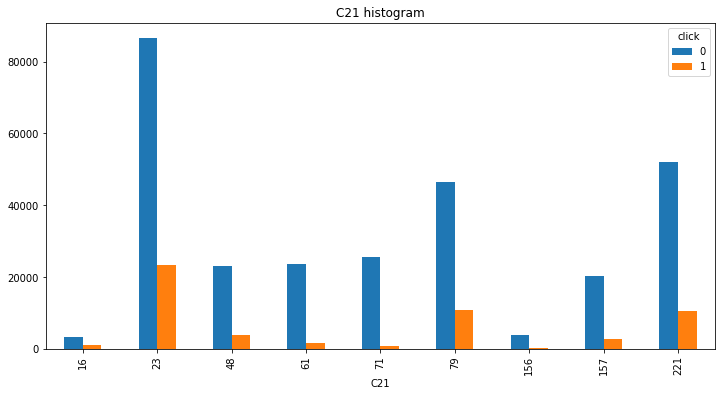

In [57]:
C15_values = df_pd.C21.sample(20).tolist()
df_c15 = df_pd[df_pd.C21.isin(C15_values)]
df_c15.groupby(['C21', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C21 histogram');

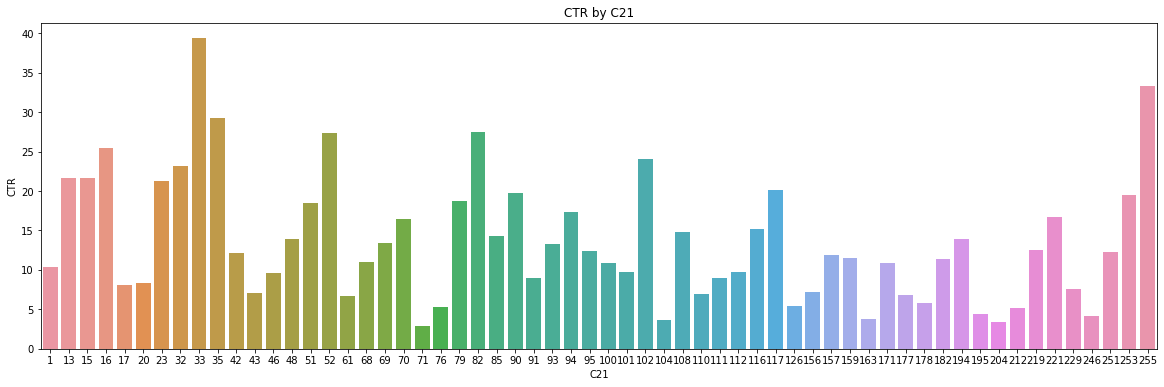

In [58]:
df_c1 = df_pd[['C21','click']].groupby(['C21']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C21','click']].groupby(['C21']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(20,6))
sns.barplot(y='CTR', x='C21', data=df_c1)
plt.title('CTR by C21');

### Banner Position

Below, we will look if the banner position has a particular effect in the number of clicks and the click-through rate.

In [59]:
print(df_pd.banner_pos.value_counts()/len(df_pd))

0    0.720784
1    0.277452
7    0.001082
2    0.000290
4    0.000176
5    0.000148
3    0.000068
Name: banner_pos, dtype: float64


In [60]:
banner_pos = df_pd.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=df_pd.loc[np.where((df_pd.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

for banner position: 0,  click through rate: 0.1643044240715665
for banner position: 1,  click through rate: 0.18421925233914335
for banner position: 2,  click through rate: 0.14482758620689656
for banner position: 3,  click through rate: 0.23529411764705882
for banner position: 4,  click through rate: 0.18181818181818182
for banner position: 5,  click through rate: 0.12162162162162163
for banner position: 7,  click through rate: 0.30868761552680224


The important banner positions are:
position 0: 72% of the data and 0.16 CTR
position 1: 28% of the data and 0.18 CTR

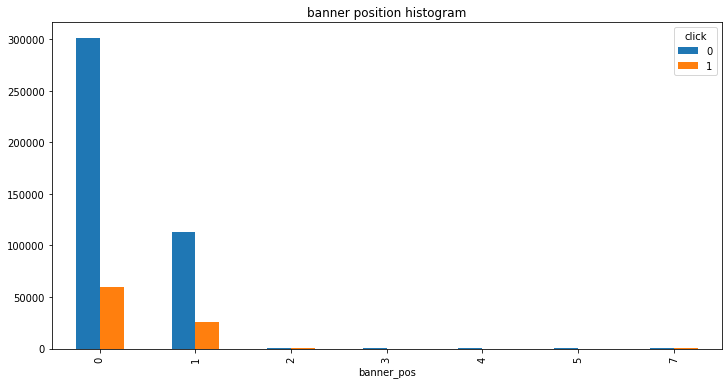

In [61]:
df_pd.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

From the plot above, we can see that there is a couple of banner positions that have a significant amount of clicks. 

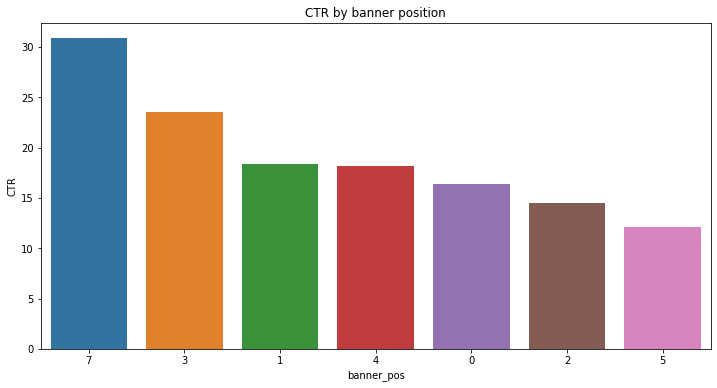

In [62]:
df_banner = df_pd[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

The same for the click-through rate. There is a particular position of the banner that have almost a 30% click-through rate.

### Device type

Below, we will look if the device type has a particular effect in the number of clicks and the click-through rate.

In [63]:
print('The impressions by device types')
print((df_pd.device_type.value_counts()/len(df_pd)))

The impressions by device types
1    0.923238
0    0.054530
4    0.019196
5    0.003034
2    0.000002
Name: device_type, dtype: float64


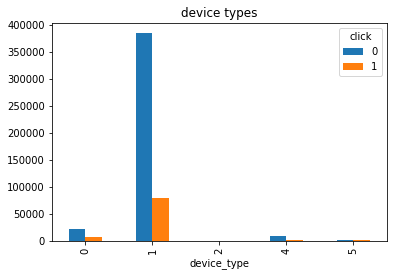

In [64]:
df_pd[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types');

Very interesting. We can see clearly that there is a specific type of `device_type` preferred comparing to the rest. 

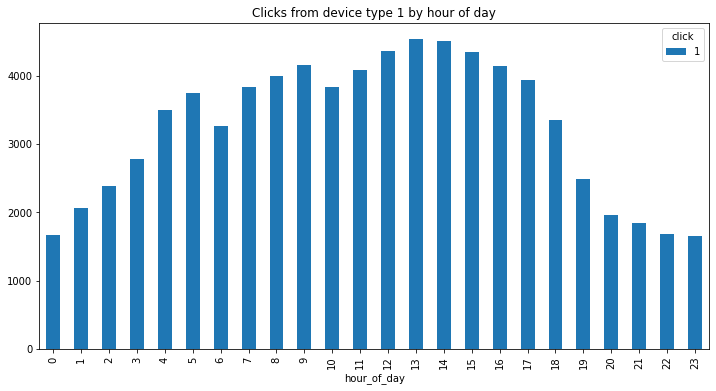

In [65]:
df_click[df_click['device_type']==1].groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type 1 by hour of day", figsize=(12,6));

Is not only is interesting that one specific type of device is massively used, but we found that the clicks are in line with the exploration done before. 

In [66]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = df_pd.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100
merged_device_type

,device_type,click,impressions,CTR
0,0,5817,27265,21.335045
1,1,78081,461619,16.914598
2,4,943,9598,9.824964
3,5,150,1517,9.887937


### User Feature

Now, the question goes to: shouldn't similar users behave in a similar way? But, how should we define a user?

We have 500k records (impressions + clicks). We have three columns that can probably help us getting to the `user` column.  The column `device_id`, has `79131` unique values. Still, is too much, but we have to look how these values are distributed. Lets look at `device_model`. `4564` unique values. However, I don't think its a good idea to look at this last column by itself. Everyone uses an iPhone there days.

In [68]:
len(df_pd.device_id.unique())

79113

In [69]:
len(df_pd.device_model.unique())

4564

In [70]:
device_id_count = pd.DataFrame(df_pd.device_id.value_counts()).rename(columns = {'device_id':'count'})
device_id_count

,count
a99f214a,412801
0f7c61dc,251
c357dbff,239
936e92fb,167
afeffc18,102
...,...
038ba74f,1
b03c67df,1
2eb94a43,1
73eb092c,1


From the table below, we can see that we have one value with `412801` observations, and the maximum of the rest with `251` observations.

In [71]:
pd.DataFrame(df_pd.device_id.value_counts().describe())

,device_id
count,79113.000000
mean,6.320074
std,1467.627680
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,412801.000000


The distribution of the `device_id` column is fairly spread. We can see the average value, 25th, 50th and 75th percentile all have the value of 1.

In [72]:
device_ip_count = pd.DataFrame(df_pd.device_ip.value_counts()).rename(columns = {'device_ip':'count'})
device_ip_count

,count
6b9769f2,2601
431b3174,1700
2f323f36,1095
930ec31d,1094
af62faf4,1076
...,...
f5ce0d04,1
a6995032,1
cb3e180a,1
32a65a6c,1


In [73]:
pd.DataFrame(df_pd.device_ip.value_counts().describe())

,device_ip
count,313632.000000
mean,1.594225
std,10.069512
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2601.000000


The same for `device_ip`. The `device_ip` should be quite interesting. However, if we had the MAC Address, we could be much more confident that we are only talking about a specific individual. 

In [74]:
device_model_count = pd.DataFrame(df_pd.device_model.value_counts()).rename(columns = {'device_id':'count'})
device_model_count

,device_model
8a4875bd,30430
1f0bc64f,17772
d787e91b,17297
76dc4769,9500
be6db1d7,9105
...,...
852e7ba5,1
dfcdc0fd,1
1d7cd1b1,1
ec61c8b7,1


In [75]:
pd.DataFrame(df_pd.device_model.value_counts().describe())

,device_model
count,4564.000000
mean,109.553024
std,755.420626
min,1.000000
25%,2.000000
50%,7.000000
75%,32.000000
max,30430.000000


In [76]:
strange_device_id = df_pd[df_pd.device_id == 'a99f214a']

In [77]:
print("Percentage with device_id = 'a99f214a': {0}%".format(strange_device_id.shape[0] / len(df_pd) * 100))

Percentage with device_id = 'a99f214a': 82.5602%


In the previous line, we can see that the number of rows with the value `a99f214a` is quite high. We have to go through other route.

In [78]:
len(strange_device_id.device_ip.unique())

254231

In [79]:
len(strange_device_id.device_model.unique())

3263

In [80]:
stats = strange_device_id.groupby(['device_ip','device_model']).size().reset_index().rename(columns={0:'count'})

In [81]:
stats

,device_ip,device_model,count
0,00002963,d4897fef,1
1,0000394e,ecb851b2,1
2,00008f94,8a4875bd,1
3,00009aad,05e70df4,1
4,0000b7a7,3b06f711,8
...,...,...,...
334798,fffe2401,84ebbcd4,1
334799,fffe2401,9c7b6730,1
334800,fffe910f,04258293,1
334801,fffec045,80351e7d,1


In [82]:
stats.describe()

,count
count,334803.000000
mean,1.232967
std,2.929319
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,442.000000


If we look for unique `device_ip` and `device_model` pairs, we can see that we see a very falt distribution of values.

In [83]:
print("Percentage of number of equal pairs 'device_ip'/'device_model' greater than 1: {0}%".format(stats[stats["count"] > 1].shape[0] / len(stats) * 100))

Percentage of number of equal pairs 'device_ip'/'device_model' greater than 1: 9.561144912082629%


We now can see that the number of rows with a repeated pair is only 9.56%. This is good to get the user, but probably my hypothesis that we can model user behaviour is not quite so.

In [84]:
print("Percentage of number of equal pairs 'device_ip'/'device_model' greater than 200: {0}%".format(stats[stats["count"] > 200].shape[0] / len(stats) * 100))

Percentage of number of equal pairs 'device_ip'/'device_model' greater than 200: 0.002986831061848311%


We now can see that the number of rows with a repeated pair over 200 counts is only 0.002986831061848311%. This is good to get the user, but probably my hypothesis that we can model user behaviour is not quite so.

In [85]:
print("Percentage of number of equal pairs 'device_ip'/'device_model' greater than 3000: {0}%".format(stats[stats["count"] > 3000].shape[0] / len(stats) * 100))

Percentage of number of equal pairs 'device_ip'/'device_model' greater than 3000: 0.0%


We now can see that the number of rows with a repeated pair over 3000 counts is only 0.002986831061848311%. This is good to get the user, but probably my hypothesis that we can model user behaviour is not quite so.

Given this, we can safely assume that the user is defined by the following function (user-defined function for Spark):

In [86]:
def get_user(device_id, device_model, device_ip):
    if device_id == "a99f214a":
        return device_model + device_ip
    else:
        return device_id
    
get_user = udf(get_user, StringType())

In [164]:
df = df.withColumn("user", get_user('device_id', 'device_model', 'device_ip'))

Below, we only will look at the top 20 more interactive users for brevity:

In [88]:
df.groupBy("user").agg(count("user")).show(10)

+----------------+-----------+
|            user|count(user)|
+----------------+-----------+
|1ccc7835bb7ae8d1|          1|
|f92bf8518aeb61e6|          1|
|49ea3580ddd2926e|          2|
|5a6d7b4a3e4b2aff|          1|
|78d9bd107103e4ce|          1|
|0153a6399a912aaa|          1|
|8a4875bdd6a14b9f|          2|
|7e4efdcd09d47c7d|          1|
|db2c36d9595c35c1|          1|
|6332421a841c3684|          1|
+----------------+-----------+
only showing top 10 rows



In [165]:
df_pd = df.toPandas()

In [90]:
top20_users = df_pd.user.value_counts()[:50].index

In [91]:
top20_users

Index(['3bb1ddd7009a7861', '3bb1ddd72f323f36', '8a4875bd6b9769f2',
       '3bb1ddd7d90a7774', '3bb1ddd7930ec31d', '3bb1ddd7af9205f9',
       '3bb1ddd7285aa37d', '3bb1ddd7af62faf4', '3bb1ddd76394f6f6',
       '8a4875bd431b3174', '0f7c61dc', 'c357dbff', 'cad4c01daf62faf4',
       '936e92fb', '03683bd4d90a7774', '03683bd4af62faf4', '03683bd42f323f36',
       '03683bd4930ec31d', '03683bd46394f6f6', '03683bd4af9205f9',
       '1f0bc64f6b9769f2', '03683bd4285aa37d', 'cad4c01d2f323f36',
       'cad4c01daf9205f9', 'cad4c01d285aa37d', 'cad4c01d930ec31d',
       '03683bd4009a7861', 'cad4c01dd90a7774', 'cad4c01d009a7861',
       'cad4c01d6394f6f6', 'd787e91b6b9769f2', '8a4875bd693bff3e',
       '8a4875bd75bb1b58', '8a4875bda8536f3a', '8b1aa260cf8f8432',
       '8a4875bdddd2926e', '8a4875bd8a014cbb', '3bb1ddd79b13a699',
       '8a4875bd488a9a3e', '8a4875bd57cd4006', '8a4875bd1cf29716', 'afeffc18',
       '711ee1206b9769f2', '8a4875bdc6563308', '8a4875bdceffea69',
       '8a4875bd0489ce3f', 'f60c2f

The plot below confirms our analysis until now:

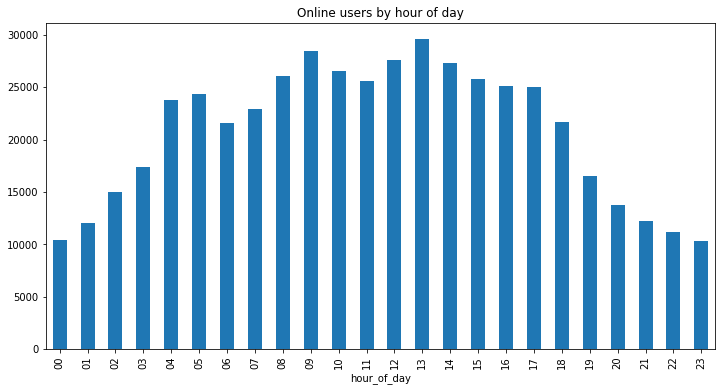

In [92]:
df_pd[['hour_of_day', 'user']].groupby(['hour_of_day', 'user']).size().unstack().fillna(0).sum(axis=1).plot(kind="bar", title="Online users by hour of day", figsize=(12,6))

In [166]:
df.show(10)

+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+----------------+
|_c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|hour_of_day|day_of_week|            user|
+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+----------------+
| 24|10005249248600844288|    0|2014-10-21 00:00:00|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e99d0c2e|    d25

This one aswell:

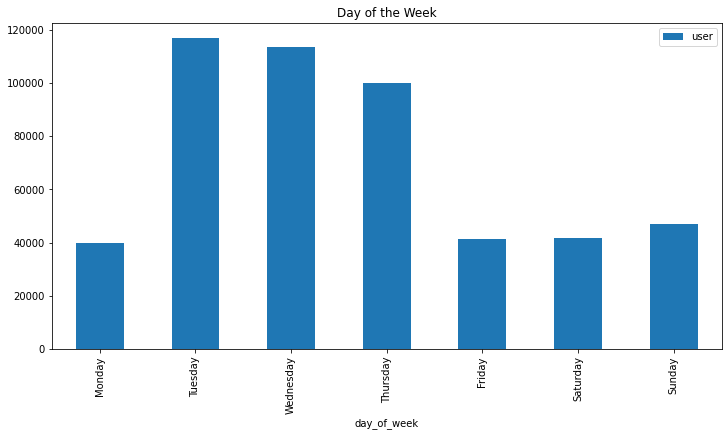

In [167]:
df_pd.groupby(['day_of_week']).agg({'user':'count'}).reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))

Now, I will look at the click-through rate for each user.

In [168]:
df_user_click_mean = df_pd.groupby(['user']).agg({'click':'mean'})

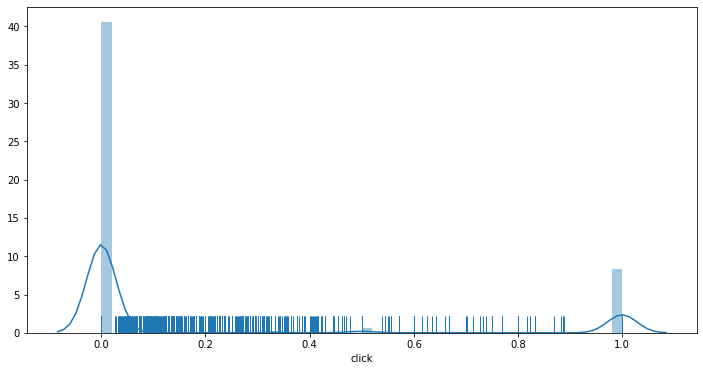

In [169]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df_user_click_mean.click, kde=True, rug=True, ax=ax)

As we can see, and as is expected, the click-through rate of each user is in conformity with the previous analysis.

In [170]:
df_pd.shape

(500000, 28)

In [171]:
top20_users = df_pd.user.value_counts().nlargest(20)

In [172]:
top20_users = top20_users.index.tolist()

In [173]:
df_top20_users = df_pd[df_pd['user'].isin(top20_users)][["user", "hour", "click"]]

In [174]:
df_top20_users

,user,hour,click
256,8a4875bd6b9769f2,2014-10-21 00:00:00,0
781,936e92fb,2014-10-21 00:00:00,0
803,c357dbff,2014-10-21 00:00:00,0
1179,8a4875bd6b9769f2,2014-10-21 00:00:00,0
1184,8a4875bd431b3174,2014-10-21 00:00:00,1
...,...,...,...
499199,0f7c61dc,2014-10-30 23:00:00,1
499331,3bb1ddd7d90a7774,2014-10-30 23:00:00,0
499698,0f7c61dc,2014-10-30 23:00:00,1
499740,8a4875bd6b9769f2,2014-10-30 23:00:00,1


In [175]:
sum_top20_users = df_top20_users.groupby(['hour', 'user']).agg({"click" : "sum"}).reset_index().fillna(0)
mean_top20_users = df_top20_users.groupby(['hour', 'user']).agg({"click" : "mean"}).reset_index()

In [176]:
sum_top20_users

,hour,user,click
0,2014-10-21 00:00:00,3bb1ddd7d90a7774,0
1,2014-10-21 00:00:00,8a4875bd431b3174,1
2,2014-10-21 00:00:00,8a4875bd6b9769f2,0
3,2014-10-21 00:00:00,936e92fb,0
4,2014-10-21 00:00:00,c357dbff,0
...,...,...,...
2131,2014-10-30 22:00:00,8a4875bd431b3174,0
2132,2014-10-30 22:00:00,8a4875bd6b9769f2,0
2133,2014-10-30 23:00:00,0f7c61dc,4
2134,2014-10-30 23:00:00,3bb1ddd7d90a7774,0


In the plots below, we will look at the sum of clicks for each user:

Text(0.5, 1.0, 'Click Sum for top 20 Interactive Users')

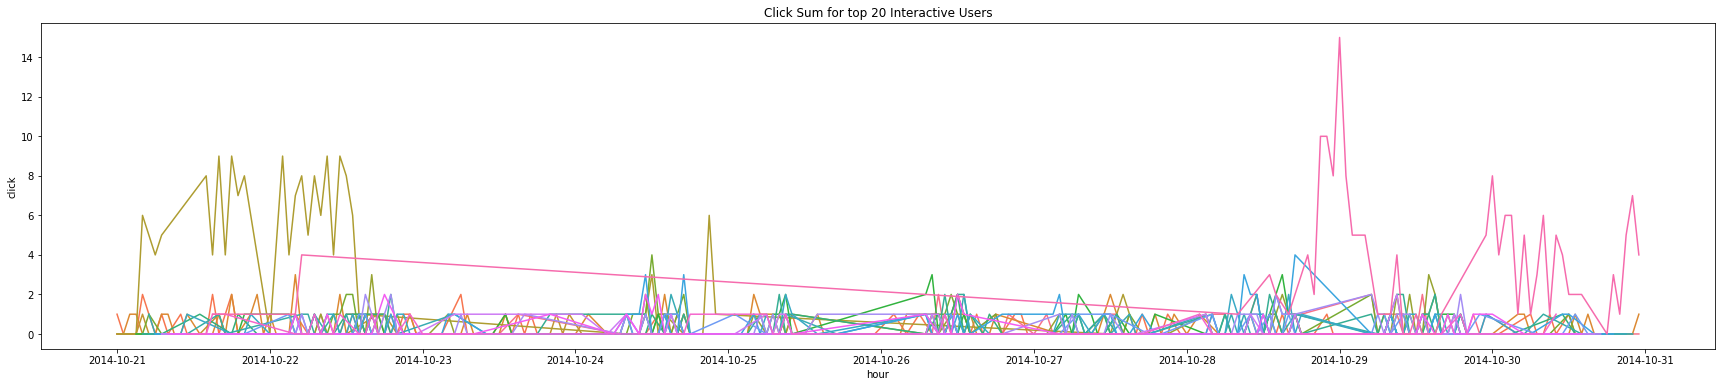

In [177]:
fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x="hour", y="click", hue="user", data=sum_top20_users, ax=ax, legend=False).set_title('Click Sum for top 20 Interactive Users')

In [179]:
df_list = list()
for name, group in df_top20_users.groupby("user"):
    group = group.resample('24h', on='hour').mean()
    group["user"] = name
    group.reset_index(inplace=True)
    df_list.append(group)
three_hourly_mean_clicks = pd.concat(df_list)

In the plots below, we will look at the CTR for each user:

Text(0.5, 1.0, 'Click Rate over 24h for top 20 Interactive Users')

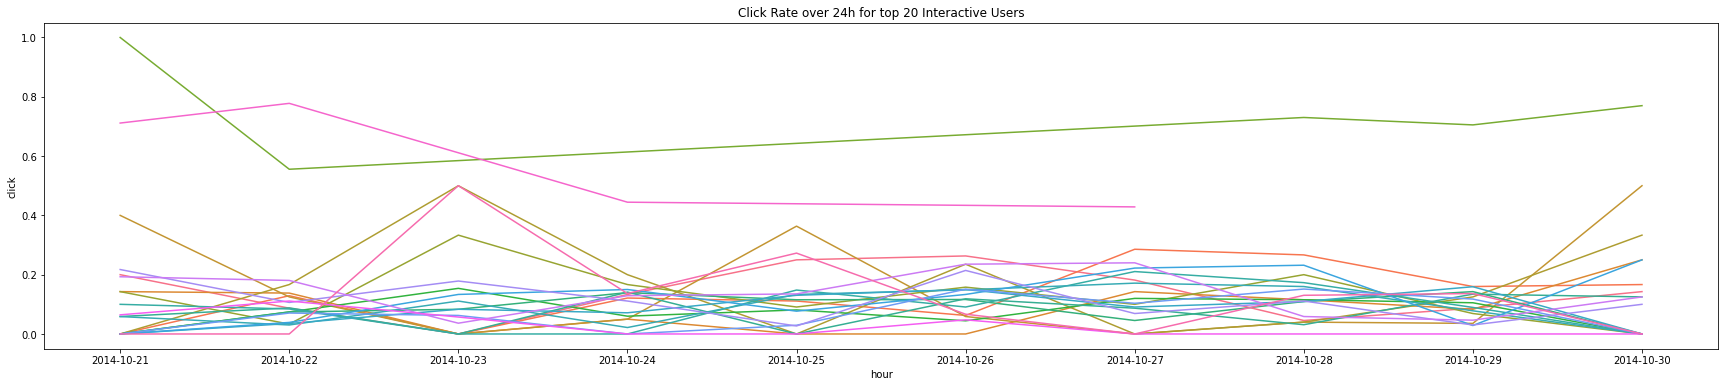

In [180]:
fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x="hour", y="click", hue="user", data=three_hourly_mean_clicks, ax=ax, legend=False).set_title('Click Rate over 24h for top 20 Interactive Users')

### Sum of clicks/user

In [181]:
df_user = df_pd.groupby(['user']).agg({'click':'sum'})

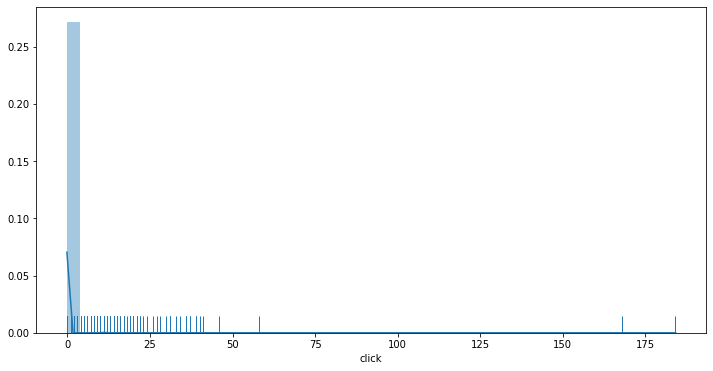

In [182]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df_user.click, kde=True, rug=True, ax=ax)

### App_id, site_id

Now, I created sort of a history of `app_id` and `site_id`. This could be an indicator of similar user behaviour.

In [183]:
df_user_app_list = df.groupby("user").agg(concat_ws(",", collect_list(df.app_id)).alias("app_list"))
df_user_site_list = df.groupby("user").agg(concat_ws(",", collect_list(df.site_id)).alias("site_list"))

In [184]:
df_user_app_list.show()

+----------------+--------------------+
|            user|            app_list|
+----------------+--------------------+
|00b1f3a7185c5989|            ecad2386|
|00b1f3a750adfac0|            ecad2386|
|00b1f3a763454196|            ecad2386|
|0135c68529902199|            98fed791|
|0153a6397c023c1d|            ecad2386|
|0153a63984593f18|            c732c8ab|
|0153a6399a912aaa|            ecad2386|
|0153a6399b6d7968|            ecad2386|
|0153a639d776fc18|            ecad2386|
|0153a639f0183302|            ecad2386|
|        018d9da1|            ecad2386|
|        018e52e6|            cf0327f9|
|        01bc7ed6|            ecad2386|
|01d57fd7bc5b6638|            ecad2386|
|01d61ca27c241329|            ecad2386|
|        02500cdc|            ecad2386|
|        0342600b|7358e05e,7358e05e...|
|034b811d858bb144|            ecad2386|
|034b811dc4e7ef74|            ecad2386|
|        035d701c|            ecad2386|
+----------------+--------------------+
only showing top 20 rows



In [185]:
df_user_site_list.show(10)

+----------------+---------+
|            user|site_list|
+----------------+---------+
|00b1f3a7185c5989| e151e245|
|00b1f3a750adfac0| e151e245|
|00b1f3a763454196| 1fbe01fe|
|0135c68529902199| 85f751fd|
|0153a6397c023c1d| 1fbe01fe|
|0153a63984593f18| 85f751fd|
|0153a6399a912aaa| d9750ee7|
|0153a6399b6d7968| d9750ee7|
|0153a639d776fc18| 6c5b482c|
|0153a639f0183302| d9750ee7|
+----------------+---------+
only showing top 10 rows



In [186]:
df = df.join(df_user_site_list, on="user", how="left_outer")

In [187]:
df.show(10)

+----------------+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+--------------------+
|            user|_c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|hour_of_day|day_of_week|           site_list|
+----------------+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+--------------------+
|d25693cee99d0c2e| 24|10005249248600844288|    0|2014-10-21 00:00:00|1005|         0|1fbe01fe|   f38

In [188]:
df = df.join(df_user_app_list, on="user", how="left_outer")

In [189]:
df.show(10)

+----------------+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+--------------------+--------------------+
|            user|_c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|hour_of_day|day_of_week|           site_list|            app_list|
+----------------+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+--------------------+--------------------+
|d25693cee99d0c2e| 24|100052492486008

Now, I created sort of a specific identifiers for places, device, place, category and banner/device profile:

In [190]:
df = df.withColumn("place_id", concat(col("site_id"), col("app_id"))) \
.withColumn("device_site", concat(col("device_id"), col("site_id"))) \
.withColumn("place_domain", concat(col("site_domain"), col("app_domain"))) \
.withColumn("place_category", concat(col("site_category"), col("app_category"))) \
.withColumn("banner_device", concat(col("banner_pos"), col("device_type")))

In [191]:
df.show(10)

+----------------+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+-----------+--------------------+--------------------+----------------+----------------+----------------+----------------+-------------+
|            user|_c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|hour_of_day|day_of_week|           site_list|            app_list|        place_id|     device_site|    place_domain|  place_category|banner_device|
+----------------+---+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+--------

In [192]:
df.printSchema()

root
 |-- user: string (nullable = true)
 |-- _c0: integer (nullable = true)
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: timestamp (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- 

In [193]:
new = df.groupBy("banner_device").agg(count("click").alias("banner_device_click_count"))

In [194]:
display(new.show(20))

+-------------+-------------------------+
|banner_device|banner_device_click_count|
+-------------+-------------------------+
|           51|                       74|
|           15|                     1409|
|           11|                   128160|
|           01|                   333118|
|           31|                       34|
|           75|                      102|
|           00|                    27265|
|           05|                        6|
|           41|                       88|
|           02|                        1|
|           04|                        2|
|           14|                     9157|
|           21|                      145|
|           74|                      439|
+-------------+-------------------------+



None

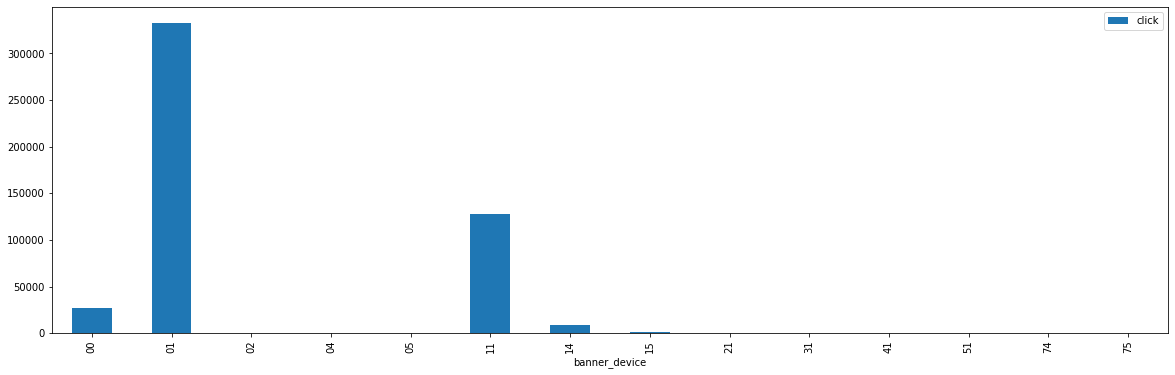

In [195]:
df_pd = df.toPandas()
df_pd.groupby(['banner_device']).agg({'click':'count'}).plot(kind="bar", figsize=(20, 6))

In [196]:
df = df.join(new, on="banner_device", how="left_outer")

In [197]:
df.show(10)

+-------------+--------+------+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----------+-----------+---------+--------+----------------+----------------+----------------+----------------+-------------------------+
|banner_device|    user|   _c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|hour_of_day|day_of_week|site_list|app_list|        place_id|     device_site|    place_domain|  place_category|banner_device_click_count|
+-------------+--------+------+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----

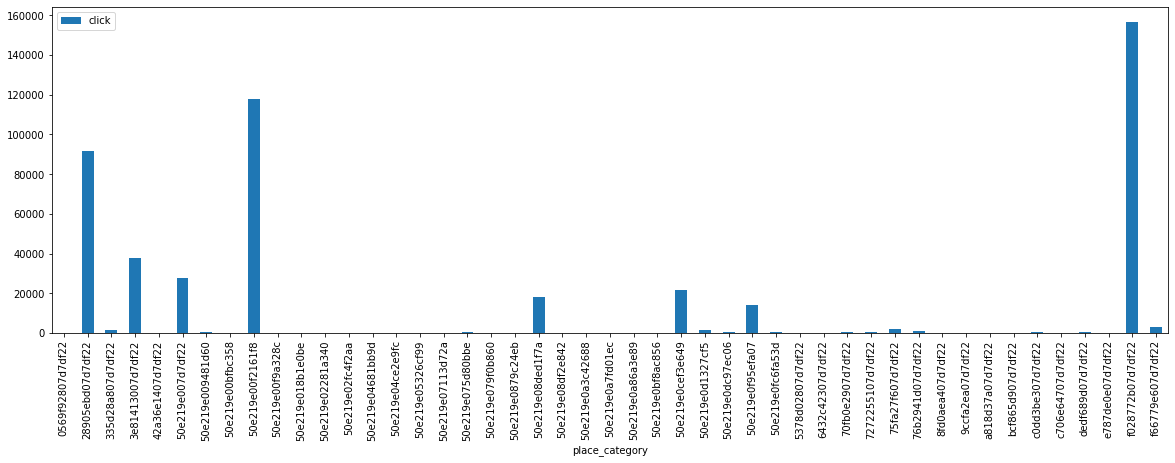

In [198]:
df_pd.groupby(['place_category']).agg({'click':'count'}).plot(kind="bar", figsize=(20, 6)) #YES

In [199]:
new2 = df.groupBy("place_category").agg(count("click").alias("place_category_click_count"))

In [200]:
new2.show(10)

+----------------+--------------------------+
|  place_category|place_category_click_count|
+----------------+--------------------------+
|5378d02807d7df22|                         4|
|50e219e009481d60|                       700|
|50e219e08ded1f7a|                     18164|
|50e219e018b1e0be|                         3|
|50e219e007d7df22|                     27881|
|335d28a807d7df22|                      1685|
|0569f92807d7df22|                       222|
|a818d37a07d7df22|                        43|
|50e219e0cef3e649|                     21825|
|50e219e0a86a3e89|                        39|
+----------------+--------------------------+
only showing top 10 rows



In [201]:
df = df.join(new2, on="place_category", how="left_outer")

In [202]:
df.show(10)

+----------------+-------------+----------------+--------+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----------+-----------+---------+--------+----------------+----------------+----------------+-------------------------+--------------------------+
|  place_category|banner_device|            user|     _c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|hour_of_day|day_of_week|site_list|app_list|        place_id|     device_site|    place_domain|banner_device_click_count|place_category_click_count|
+----------------+-------------+----------------+--------+--------------------+-----+-------------------+----+----------+-----

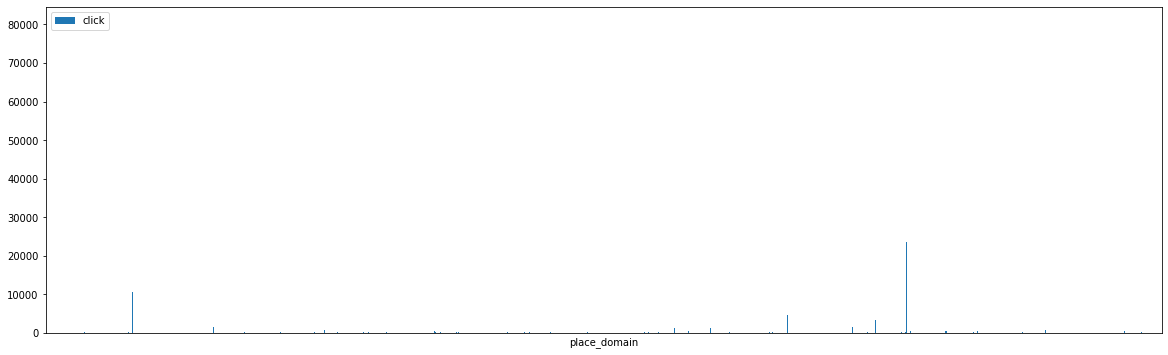

In [203]:
df_pd.groupby(['place_domain']).agg({'click':'count'}).plot(kind="bar", figsize=(20, 6), xticks=[]) #YES

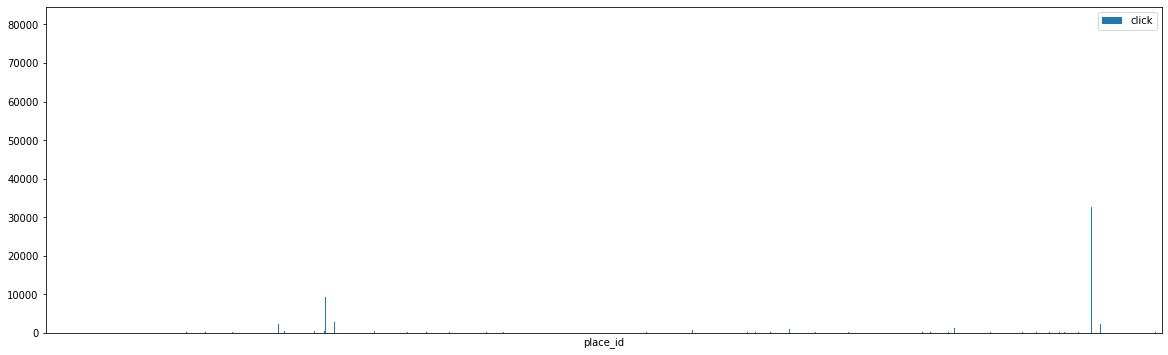

In [204]:
df_pd.groupby(['place_id']).agg({'click':'count'}).plot(kind="bar", figsize=(20, 6), xticks=[]) #YES

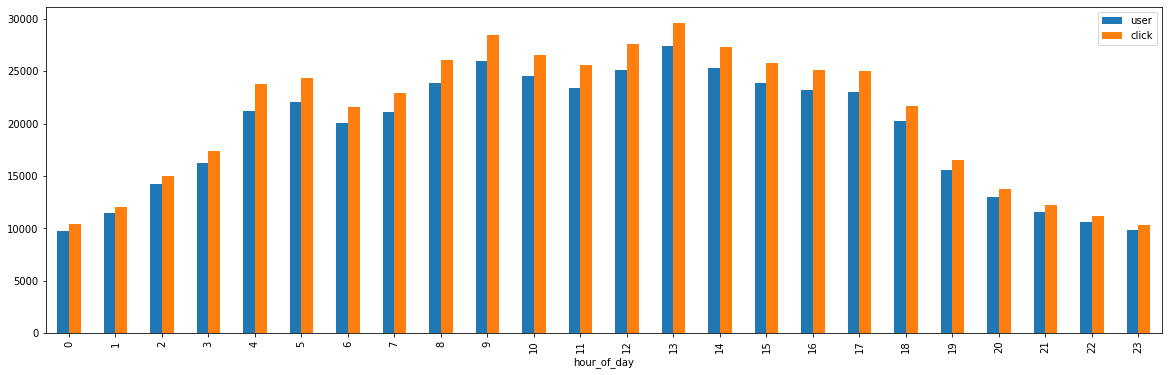

In [205]:
df_pd.groupby(['hour_of_day']).agg({"user": lambda x: x.nunique(), 'click':"count"}).plot(kind="bar", figsize=(20, 6)) # YES - user!

In [206]:
new3 = df.groupBy("hour_of_day").agg(count("click").alias("hour_of_day_click_count"), countDistinct("user").alias("user_hour_count"))

In [207]:
new3.show(10)

+-----------+-----------------------+---------------+
|hour_of_day|hour_of_day_click_count|user_hour_count|
+-----------+-----------------------+---------------+
|         12|                  27609|          25121|
|         22|                  11170|          10581|
|          1|                  12008|          11442|
|         13|                  29648|          27385|
|          6|                  21577|          20018|
|         16|                  25122|          23245|
|          3|                  17354|          16270|
|         20|                  13730|          13025|
|          5|                  24333|          22104|
|         19|                  16485|          15537|
+-----------+-----------------------+---------------+
only showing top 10 rows



In [208]:
df = df.join(new3, how="left_outer", on=["hour_of_day"])

In [209]:
df.show(10)

+-----------+----------------+-------------+----------------+--------+--------------------+-----+-------------------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+-----------+--------------------+--------------------+----------------+----------------+----------------+-------------------------+--------------------------+-----------------------+---------------+
|hour_of_day|  place_category|banner_device|            user|     _c0|                  id|click|               hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|day_of_week|           site_list|            app_list|        place_id|     device_site|    place_domain|banner_device_click_count|place_category_click_count|hour_of_day_click_count|user_hour_count

In [210]:
new4 = df.groupBy("hour_of_day", "user").agg(count("click").alias("hour_of_day_user_click_count"),
                                             countDistinct("site_id").alias("hourly_site_id_count"))

In [215]:
new4.show(10, False)

+-----------+----------------+----------------------------+--------------------+
|hour_of_day|user            |hour_of_day_user_click_count|hourly_site_id_count|
+-----------+----------------+----------------------------+--------------------+
|12         |5b1faad59799c86d|1                           |1                   |
|12         |9f221a98        |1                           |1                   |
|12         |f60c2fd3af62faf4|4                           |3                   |
|12         |3bb1ddd76a31c752|1                           |1                   |
|12         |9c7b67302d6515c7|1                           |1                   |
|12         |3a016a37        |1                           |1                   |
|12         |137b564a        |1                           |1                   |
|12         |936e92fb        |2                           |1                   |
|12         |2ea4f8ba10acda51|1                           |1                   |
|12         |54c4ae39       

In [214]:
df.printSchema()

root
 |-- hour_of_day: integer (nullable = true)
 |-- place_category: string (nullable = true)
 |-- banner_device: string (nullable = true)
 |-- user: string (nullable = true)
 |-- _c0: integer (nullable = true)
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: timestamp (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: inte

In [223]:
df.coalesce(1).write.mode('overwrite').csv("../data/featurized-data", header=True)